In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm import utils
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm import scheduler
from torch.optim import Adam
import glob
from tqdm.notebook import tqdm
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
from PIL import Image
import torchvision
from pathlib import Path 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The model will be running on', device, 'device')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The model will be running on cuda:0 device


In [3]:
! pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=101740 sha256=1c97196c1f23684dd23a137b716fa6ef7ef3d2891cb131b6d292db3b4ba78530
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools


In [4]:
! pip install git+https://github.com/facebookresearch/segment-anything.git 

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kmbv_j1v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kmbv_j1v
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... - \ done


In [5]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth 

--2023-07-29 17:45:04--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.86.94, 18.155.86.114, 18.155.86.80, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.86.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   184MB/s    in 1.9s    

2023-07-29 17:45:06 (184 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm import utils
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm import scheduler
from torch.optim import Adam
import glob
from tqdm.notebook import tqdm
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
from PIL import Image
import torchvision

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The model will be running on', device, 'device')

The model will be running on cuda:0 device


In [7]:
meta = pd.read_csv('/kaggle/input/meta-data-segmentation/meta_seg.csv')

In [8]:
meta.head(3)

,Unnamed: 0,Image,Mask
0,0,Meta_data/Mass-Training_P_00001_LEFT_CC/Mass-T...,Meta_data/Mass-Training_P_00001_LEFT_CC/Mass-T...
1,1,Meta_data/Mass-Training_P_00001_LEFT_MLO/Mass-...,Meta_data/Mass-Training_P_00001_LEFT_MLO/Mass-...
2,2,Meta_data/Mass-Training_P_00004_LEFT_CC/Mass-T...,Meta_data/Mass-Training_P_00004_LEFT_CC/Mass-T...


In [9]:
import torchvision
import torch
# bbox_coords = {}

# for f in sorted(Path('/kaggle/input/stamp-verification-staver-dataset/ground-truth-maps/ground-truth-maps').iterdir())[:100]:
#     k = f.stem[:-3]
#     if k not in stamps_to_exclude:
#         im = cv2.imread(f.as_posix())
#         gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
#         contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
#         if len(contours) > 1:
#             x,y,w,h = cv2.boundingRect(contours[0])
#             height, width, _ = im.shape
#             bbox_coords[k] = np.array([x, y, x + w, y + h])
#             bbox_coords[k] = 0

In [10]:
from torchvision.io import read_image
ground_truth_masks = {}
bbox_coords = {}

for k in tqdm(meta.Image):
    k
    gt_grayscale = cv2.imread(f"/kaggle/input/meta-data-segmentation/Meta_data/{k.replace('.png', '')}_mask.png", cv2.IMREAD_GRAYSCALE)
    mask = read_image(f"/kaggle/input/meta-data-segmentation/Meta_data/{k.replace('.png', '')}_mask.png",torchvision.io.ImageReadMode.GRAY)
    ground_truth_masks[k] = gt_grayscale # Chuyển nền thành false, và mask thành true
    # We get the unique colors, as these would be the object ids.
    obj_ids = torch.unique(mask)
    #print(obj_ids)
    # first id is the background, so remove it.
    obj_ids = obj_ids[0]

    # split the color-encoded mask into a set of boolean masks.
    # Note that this snippet would work as well if the masks were float values instead of ints.
    masks = mask != obj_ids # chuyển màu nên thành true
    #print(masks.size())
    #print(torchvision.ops.masks_to_boxes(masks))
#     print(masks)
#     print(k)
    bbox_coords[k] = torchvision.ops.masks_to_boxes(masks).numpy()[0]

  0%|          | 0/1166 [00:00<?, ?it/s]

In [11]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [12]:
name = 'Meta_data/Mass-Training_P_00001_LEFT_CC/Mass-Training_P_00001_LEFT_CC.png'
# name = 
bbox_coords[name]

array([ 70., 502., 173., 616.], dtype=float32)

In [13]:
ground_truth_masks[name]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

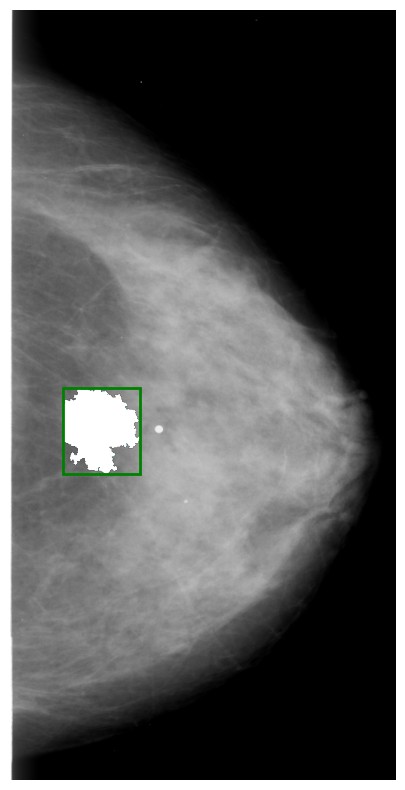

In [14]:
name = 'Meta_data/Mass-Training_P_00001_LEFT_CC/Mass-Training_P_00001_LEFT_CC.png'
image = cv2.imread('/kaggle/input/meta-data-segmentation/Meta_data/Meta_data/Mass-Training_P_00001_LEFT_CC/Mass-Training_P_00001_LEFT_CC.png')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

In [15]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [16]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

In [17]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
# for k in tqdm(bbox_coords.keys()):
def conver_to_sam_format(k):
#     print(k)
    image = cv2.imread(f'/kaggle/input/meta-data-segmentation/Meta_data/{k}')
#     print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    '''
    Thay đổi kích thước ảnh sao cho phù hợp với model 
    '''
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    '''
    Thay đổi thứ tự kênh màu của tensor ảnh input_image_torch từ (H, W, C) sang (C, H, W) và thêm chiều batch đầu tiên (None).
    Kết quả là transformed_image, tensor này chứa ảnh đã được tiền xử lý và sẵn sàng đưa vào mô hình.
    '''
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    '''
    Tiền xử lý dữ liệu trước khi đưa vào model 
    '''
    input_image = sam_model.preprocess(transformed_image)
    
    original_image_size = image.shape[:2]  # Lấy kích thước ảnh nguyên bản 
    input_size = tuple(transformed_image.shape[-2:]) # Lấy kích thước ảnh đã transform
    return input_image, input_size, original_image_size
#     transformed_data[k]['image'] = input_image    # Lưu trử ảnh đã được xử ký chuyển thành tensor
#     transformed_data[k]['input_size'] = input_size   # Lưu trử kích thước ảnh tensor
#     transformed_data[k]['original_image_size'] = original_image_size

In [18]:
#PyTorch
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [19]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = IoULoss()
# loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())

In [20]:
transform = ResizeLongestSide(sam_model.image_encoder.img_size)

In [21]:
def save_model(name_model, epochs, model, optimizer, criterion, pretrained="True"):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"/kaggle/working/{name_model}_{epochs}.pth")
    print(f'Save model --> {name_model}_{epochs}.pth')

In [22]:
from statistics import mean
from tqdm.notebook import tqdm

# from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 50
losses = []

for epoch in tqdm(range(num_epochs), total=num_epochs):
    epoch_losses = []
    best_loss = .0
    # Just train on the first 20 examples
    for k in tqdm(keys, total=len(keys)):
        input_image, input_size, original_image_size = conver_to_sam_format(k)
#         input_image = transformed_data[k]['image'].to(device)
#         input_size = transformed_data[k]['input_size']
#         original_image_size = transformed_data[k]['original_image_size']

        # No grad here as we don't want to optimise the encoders
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)

            prompt_box = bbox_coords[k]
            box = transform.apply_boxes(prompt_box, original_image_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]

            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
              points=None,
              boxes=box_torch,
              masks=None,
            )
        low_res_masks, iou_predictions = sam_model.mask_decoder(
          image_embeddings=image_embedding,
          image_pe=sam_model.prompt_encoder.get_dense_pe(),
          sparse_prompt_embeddings=sparse_embeddings,
          dense_prompt_embeddings=dense_embeddings,
          multimask_output=False,
        )

        upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

        gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        
    losses.append(mean(epoch_losses))
    if mean(epoch_losses) > best_loss:
        save_model('sam', epoch, sam_model, optimizer, loss_fn)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_0.pth
EPOCH: 0
Mean loss: 0.9880972259245033


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_1.pth
EPOCH: 1
Mean loss: 0.9886712266793586


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_2.pth
EPOCH: 2
Mean loss: 0.9889834109649036


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_3.pth
EPOCH: 3
Mean loss: 0.9875507340934223


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_4.pth
EPOCH: 4
Mean loss: 0.9876733042977073


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_5.pth
EPOCH: 5
Mean loss: 0.9877083374133037


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_6.pth
EPOCH: 6
Mean loss: 0.9880184035358461


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_7.pth
EPOCH: 7
Mean loss: 0.9898749988136324


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_8.pth
EPOCH: 8
Mean loss: 0.991021165103487


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_9.pth
EPOCH: 9
Mean loss: 0.9910863723803957


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_10.pth
EPOCH: 10
Mean loss: 0.9911213065297894


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_11.pth
EPOCH: 11
Mean loss: 0.9911287605864719


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_12.pth
EPOCH: 12
Mean loss: 0.9911310931421676


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_13.pth
EPOCH: 13
Mean loss: 0.9911385618699763


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_14.pth
EPOCH: 14
Mean loss: 0.9911490497826303


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_15.pth
EPOCH: 15
Mean loss: 0.9911504285106528


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_16.pth
EPOCH: 16
Mean loss: 0.9911424036091433


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_17.pth
EPOCH: 17
Mean loss: 0.9911430869155642


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_18.pth
EPOCH: 18
Mean loss: 0.9911560545552451


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_19.pth
EPOCH: 19
Mean loss: 0.9911666690383113


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_20.pth
EPOCH: 20
Mean loss: 0.9911668412067878


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_21.pth
EPOCH: 21
Mean loss: 0.9911666090758342


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_22.pth
EPOCH: 22
Mean loss: 0.9911668969263957


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_23.pth
EPOCH: 23
Mean loss: 0.9911669221280165


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_24.pth
EPOCH: 24
Mean loss: 0.9911668450407057


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_25.pth
EPOCH: 25
Mean loss: 0.9911667558893331


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_26.pth
EPOCH: 26
Mean loss: 0.9911666784953089


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_27.pth
EPOCH: 27
Mean loss: 0.9911666322838176


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_28.pth
EPOCH: 28
Mean loss: 0.9911667081953935


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_29.pth
EPOCH: 29
Mean loss: 0.9911667992381658


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_30.pth
EPOCH: 30
Mean loss: 0.9911668978976549


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_31.pth
EPOCH: 31
Mean loss: 0.9911668342034976


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_32.pth
EPOCH: 32
Mean loss: 0.9911669413998442


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_33.pth
EPOCH: 33
Mean loss: 0.9911669397640391


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_34.pth
EPOCH: 34
Mean loss: 0.991167027739677


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_35.pth
EPOCH: 35
Mean loss: 0.9911665802958899


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_36.pth
EPOCH: 36
Mean loss: 0.9911668314941956


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_37.pth
EPOCH: 37
Mean loss: 0.9911667572184247


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_38.pth
EPOCH: 38
Mean loss: 0.991166891865624


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_39.pth
EPOCH: 39
Mean loss: 0.9911677266884832


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_40.pth
EPOCH: 40
Mean loss: 0.9911676602339049


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_41.pth
EPOCH: 41
Mean loss: 0.9911676410643151


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_42.pth
EPOCH: 42
Mean loss: 0.9911676675439085


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_43.pth
EPOCH: 43
Mean loss: 0.9911676004247846


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_44.pth
EPOCH: 44
Mean loss: 0.9911677307779957


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_45.pth
EPOCH: 45
Mean loss: 0.9911678006575406


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_46.pth
EPOCH: 46
Mean loss: 0.9911678249390211


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_47.pth
EPOCH: 47
Mean loss: 0.9911679298350169


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_48.pth
EPOCH: 48
Mean loss: 0.9911679285059253


  0%|          | 0/1166 [00:00<?, ?it/s]

Save model --> sam_49.pth
EPOCH: 49
Mean loss: 0.991167835929586


In [23]:
data = pd.DataFrame(columns = ['Loss IOU'], data = [losses])

ValueError: 1 columns passed, passed data had 50 columns

In [ ]:
data.to_csv('/kaggle/working/loss.csv')

In [ ]:
mean_losses = [x for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

In [ ]:
# Load up the model with default weights
checkpoint_new = 'sam_0.pth'
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_new = sam_model_registry[model_type](checkpoint=checkpoint)

sam_model_orig.to(device);
sam_model_new.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model_new)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[0]
image = cv2.imread(f'/kaggle/input/meta-data-segmentation/Meta_data/{k}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

In [ ]:
# masks_tuned
masks_tuned = (masks_tuned != 0)

In [ ]:
masks_tuned

In [ ]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()